In [175]:
#常用库准备：numpy，pandas，matplotlib
from numpy import *
from numpy.linalg import multi_dot
import pandas as pd
import matplotlib.pyplot as plt

In [176]:
#pip install cufflinks

In [177]:
#加载画图库
import cufflinks as cf
cf.set_config_file(
    offline=True,
    dimensions=(1000,6000),
    theme='henanigans')
import plotly.express as px
px.defaults.width = 1000
px.defaults.height = 600

#忽略警告提醒
import warnings 
warnings.filterwarnings('ignore')

In [178]:
#解决中文问题
plt.rcParams['font.sans-serif'] = ['SimHei']

#解决负号问题
plt.rcParams['axes.unicode_minus'] = False

In [179]:
#导入外部数据
#加载数据
file_path = r'C:\Users\苏畅\Desktop\有效边界和市场组合.csv'
data = pd.DataFrame(pd.read_csv(file_path,index_col=0,parse_dates=True)).dropna()
data.head()

,比亚迪,贵州茅台,东方财富,宁德时代,广发证券,中国银河
2020-01-02,48.17,1130.00,15.90,107.52,15.46,12.47
2020-01-03,48.04,1078.56,16.00,109.55,15.54,12.00
2020-01-06,48.28,1077.99,16.15,109.09,15.57,11.88
2020-01-07,48.05,1094.53,16.14,108.50,15.66,11.87
2020-01-08,47.28,1088.14,15.54,109.60,15.09,11.40


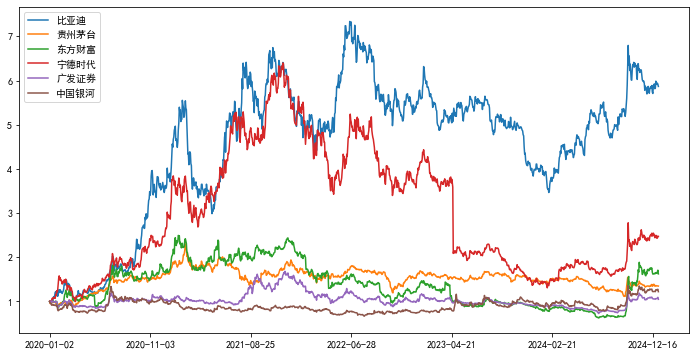

In [180]:
#将股价按首个交易日进行归一化处理并可视化
(data/data.iloc[0]).plot(figsize =(12,6))
plt.show()

In [181]:
#按照对数收益率的计算公式得到股票收益率
returns = log(data/data.shift(1)).dropna()

In [182]:
returns.describe()

,比亚迪,贵州茅台,东方财富,宁德时代,广发证券,中国银河
count,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.001461,0.000247,0.000400,0.000748,0.000039,0.000165
std,0.028654,0.018519,0.032228,0.033826,0.021260,0.023251
min,-0.105377,-0.082345,-0.230010,-0.541703,-0.105525,-0.105284
25%,-0.014236,-0.008769,-0.014278,-0.015558,-0.009991,-0.011377
50%,-0.000252,-0.000479,-0.000668,-0.000796,-0.001214,-0.000998
75%,0.014703,0.009311,0.012836,0.015660,0.008834,0.010035
max,0.095317,0.090792,0.182322,0.171451,0.095537,0.095641


In [183]:
#年化收益率及波动
pd.DataFrame({
    '年化收益':round(returns.mean()*252*100,2),
    '年化波动':round(returns.std()*252*100,2)
}).iplot(kind='bar',title='年化收益率及波动(%)',shared_xaxes=False,subplots= True,layout=dict(height=400,xaxis=dict(title='资产'),yaxis=dict(title='百分比 (%)')))

In [184]:
#定义一个等权重的投资组合
symbols = data.iloc[0].tolist()
numofasset = len(symbols)
weights = numofasset*[1./numofasset]
weights = array(weights)[:,newaxis]
weights

array([[0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667]])

In [185]:
#计算股票的年化收益率
R_mean = array(returns.mean()*252*10)[:,newaxis]
R_mean

array([[3.68221389],
       [0.62244796],
       [1.00889537],
       [1.88494217],
       [0.09857818],
       [0.41606304]])

In [186]:
#计算投资组合的预期收益
R_port = weights.T @ R_mean
print('投资组合的预期收益：',R_port)

投资组合的预期收益： [[1.28552344]]


In [187]:
#计算股票的协方差矩阵并做年化处理
R_cov = returns.cov()
R_cov

,比亚迪,贵州茅台,东方财富,宁德时代,广发证券,中国银河
比亚迪,0.000821,0.000194,0.000358,0.000501,0.000200,0.000179
贵州茅台,0.000194,0.000343,0.000251,0.000216,0.000154,0.000152
东方财富,0.000358,0.000251,0.001039,0.000428,0.000464,0.000465
宁德时代,0.000501,0.000216,0.000428,0.001144,0.000219,0.000218
广发证券,0.000200,0.000154,0.000464,0.000219,0.000452,0.000334
中国银河,0.000179,0.000152,0.000465,0.000218,0.000334,0.000541


In [188]:
#计算投资组合收益波动率
var = multi_dot([weights.T,R_cov,weights])
vol_port = sqrt(var)

print('投资组合收益波动率:',vol_port)

投资组合收益波动率: [[0.01900801]]


In [189]:
#定义一个组合函数
def portfolio_simulation(returns):
    rets = []; vols = [];wts=[]
    #模拟5000个不同权重的组合
    for i in range (5000):
       #产生随机权重
       weights = random.random(numofasset)[:newaxis]
       #设置权重之和为1
       weights /= sum(weights)
       
       #记录组合的收益、波动、权重
       rets.append(weights.T @ array(returns.mean()*252)[:,newaxis])
       vols.append(sqrt(multi_dot([weights.T,returns.cov()*252,weights])))
       wts.append(weights.flatten())
    #记录组合个数据
    portdf = 100*pd.DataFrame({
        'port_rets':array(rets).flatten(),
        'port_vols':array(vols).flatten(),
        'weights':list(array(wts))
         })
    portdf['Sharpe_ratio'] = portdf['port_rets']/portdf['port_vols']
    return round(portdf,2)

In [190]:
temp = portfolio_simulation(returns)
temp.head()

,port_rets,port_vols,weights,Sharpe_ratio
0,13.50,31.07,"[13.865579703707418, 20.680918397534363, 10.32258942498237, 29.784631351571345, 19.107354832073728, 6.238926290130777]",0.43
1,12.96,29.69,"[20.15468013967293, 15.903812798724742, 15.229323442337042, 9.2197435714948, 11.500651529665232, 27.991788518105242]",0.44
2,13.68,30.27,"[19.13778877684557, 16.52753371488012, 16.016838244286955, 16.94914615482302, 16.07390681849699, 15.294786290667348]",0.45
3,14.43,30.84,"[20.17473042826125, 21.006435240591063, 17.1670788510791, 19.80181757953144, 21.28165894204097, 0.5682789584961766]",0.47
4,12.72,35.28,"[6.9946045286567795, 6.363223599207999, 28.75199508401021, 32.94567778922338, 12.454486943756628, 12.490012055144996]",0.36


In [191]:
#找夏普比率最高的组合
temp.iloc[temp.Sharpe_ratio.idxmax()]

port_rets                                                                                                                      25.13
port_vols                                                                                                                      34.88
weights         [61.79201410801212, 14.923881519261723, 10.71332901504887, 0.9249957256183867, 9.26179235272485, 2.3839872793340495]
Sharpe_ratio                                                                                                                    0.72
Name: 4440, dtype: object

In [192]:
#模拟可视化
fig = px.scatter(
    temp,x='port_vols',y='port_rets',color='Sharpe_ratio',
    labels={'port_vols':'预期波动','PORT_rets':'预期收益','Sharpe_ratio':'夏普比率'},
    title='蒙特卡洛模拟资产组合'
    ).update_traces(mode='markers', marker=dict(symbol='cross'))
#绘制最大夏普比率的组合
fig.add_scatter(
    mode='markers',
    x=[temp.iloc[temp.Sharpe_ratio.idxmax()]['port_vols']],
    y=[temp.iloc[temp.Sharpe_ratio.idxmax()]['port_rets']],
    marker=dict(color='RoyalBlue',size=20,symbol='star'),
    name='市场组合'
    ).update(layout_showlegend=False)
fig.update_xaxes(showspikes=True)
fig.update_xaxes(showspikes=True)
fig.show()